# Image generation with Evolutionary algorithm

### Basic imports

In [59]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display
import cv2

### Some display functions

In [2]:
def show_gray_img(img):
    fig = plt.figure(figsize=(20,20))
    plt.imshow(img, cmap='gray')
    
    
def show_history(history):
    plt.plot(history)
    plt.show()

### Image preprocessing

In [67]:
def get_gray_img(img_name):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def compress_img(img, ratio):
    img = cv2.resize(img, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_CUBIC)
    return img


def apply_thresh(img, thresh):
    img[img<thresh]=0
    img[img>thresh]=255
    return img

### Losses

In [60]:
#IoU
def intersection_loss(x, y):
    x_power = np.count_nonzero(x)
    y_power = np.count_nonzero(y)
    union_power = np.count_nonzero(x+y)
    intersection_power = x_power + y_power - union_power
    loss = 1 - intersection_power / union_power
    return loss

# Mean squared error
def mse(x,y):
    x_inds = np.count_nonzero(x)
    mse = np.sum((x-y)**2)/np.prod(x.shape)
    return mse

### Population itself

In [44]:
class LinePopulation:
    
    def __init__(self, shape, pop_size, target, loss, min_len, max_len, thickness=2):
        self.shape = shape
        self.pop_size = pop_size
        self.target = target
        self.loss = loss
        self.min_len = min_len
        self.max_len = max_len
        self.thickness = thickness
        self.individuals = self.generate_individuals(pop_size)

        
    def generate_color(self):
        return  np.random.random(3) if len(self.shape)>2  else np.random.random()
        
        
    def generate_individuals(self, amount):
        '''
        Generates amount of lines (x1,y1,x2,y2)
        '''
        # Generate random pints on the grid
        p1 = np.random.rand(amount, 2)*(self.shape[:2][::-1])
        p2 = np.random.rand(amount, 2)*(self.shape[:2][::-1])
        # Get length of future segment 
        l = self.min_len + np.random.random(amount).reshape(-1,1)*(self.max_len-self.min_len)
        # Length of current segment
        L = np.linalg.norm(p2-p1, axis=1).reshape(-1,1)
        # Normalize vector to be needed length
        p2 = p1 + (p2-p1)*l/L
        p1 = p1.astype(np.int)
        p2 = p2.astype(np.int)
        # cutting out of bounds
        p2[:,0][p2[:,0]<0] = 0
        p2[:,1][p2[:,1]<0] = 0
        p2[:,0][p2[:,0]>=self.shape[1]] = self.shape[1]-1
        p2[:,1][p2[:,1]>=self.shape[0]] = self.shape[0]-1
        return np.concatenate([p1,p2], axis=-1)
    
    
    def draw_individuals(self, individuals):
        '''
        Creates black grid, draw white lines and returns 
        grid
        '''
        img = np.zeros(self.shape, dtype=np.float)
        for line in individuals:
            color = self.generate_color()
            cv2.line(img,tuple(line[:2]), tuple(line[2:4]), color, np.random.randint(1,self.thickness+1))
        return img
    
    
    def apply_loss(self, individual):
        return self.loss(self.draw_individuals([individual]), self.target)
    
    
    def sort_individuals(self, individuals):
        individuals = list(individuals)
        losses = [self.apply_loss(individual) for individual in individuals]
        individuals = [x[1] for x in sorted(zip(losses, individuals), key=lambda x: x[0])]
        individuals = np.asarray(individuals)
        return individuals
    
    
    def evaluate_individuals(self, individuals):
        return np.sum([self.apply_loss(individual) for individual in individuals])
    
    
    def get_top_individuals(self, individuals, percentile=0.3):
        return individuals[:int(len(individuals)*percentile)]

### Define evolution run

In [66]:
def evolve(pop, new_pop_size, alive_part):
    sorted_inds = pop.sort_individuals(pop.individuals)
    top_inds = pop.get_top_individuals(sorted_inds, alive_part)
    new_inds = pop.generate_individuals(new_pop_size-len(top_inds))
    pop.individuals = np.concatenate([top_inds, new_inds])
    
    img = pop.draw_individuals(top_inds)
    error = pop.evaluate_individuals(top_inds)
        
    return error, img

### Load the image

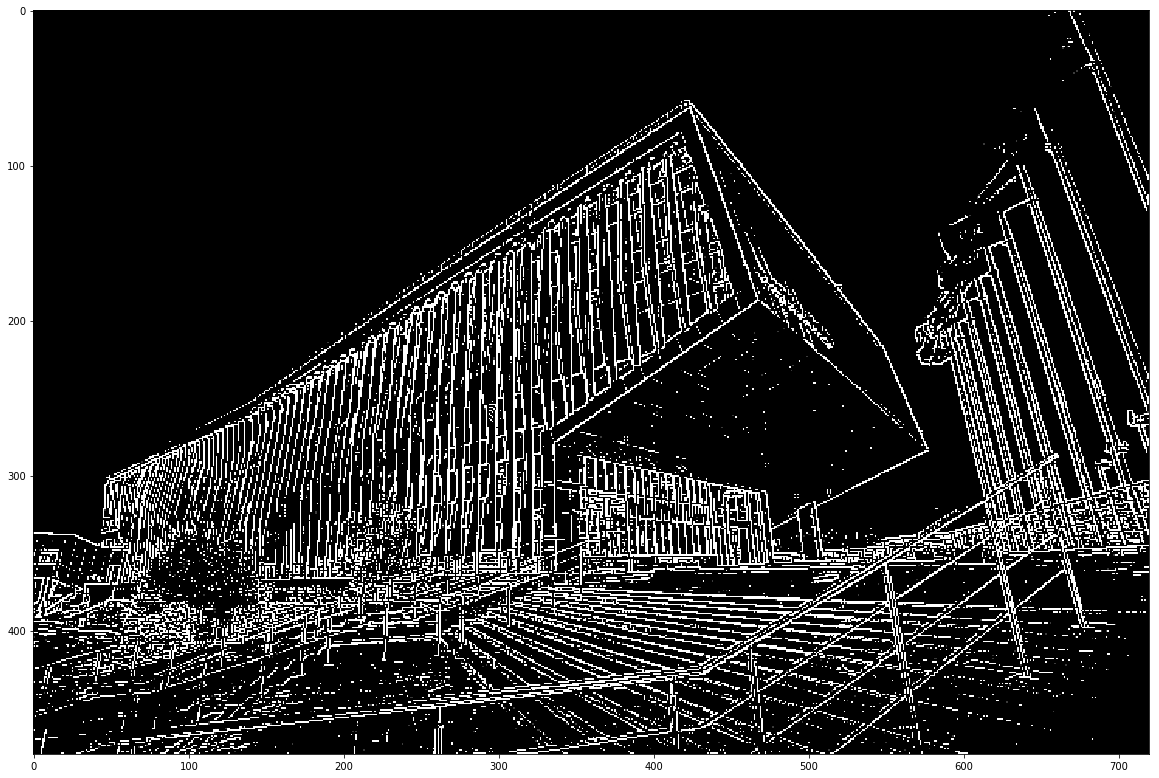

In [68]:
# Image name
img_name = '/project/data/images/inno.jpg'
# Make image gray and compress
img = get_gray_img(img_name)
img = compress_img(img, 0.3)
# Apply laplacian filter and 
img = cv2.Laplacian(img, cv2.CV_16U, ksize=3)
#threshold to reduce noize
apply_thresh(img, 60)
# from (rgb) (255,255,255) to (1,1,1)
img = img/255.
# Show the image
show_gray_img(img)

### Define evolution params

In [65]:
# Amount of lines
POP_SIZE = 5000
# Target image
TARGET = img
# Shape of target image
SHAPE = img.shape
# Loss to be applied
loss = mse
# Params of line min length, max length, thickness
min_len, max_len, thickness = (5, 20, 1)

# Create population
pop = LinePopulation(SHAPE, POP_SIZE, TARGET, loss, min_len, max_len, thickness)

In [ ]:
# History to see error decreasing
history = []
EPOCHS = 100
SELECTION_PART = 0.6

# Destination to save images
EXPERIMENT_DIR = '/project/data/inno_exp_3'

# Run the evolution
for _ in range(1000):
    error, img = evolve(pop, POP_SIZE, SELECTION_PART)
    history.append(error)
    cv2.imwrite('{}/img{}.png'.format(EXPERIMENT_DIR, _), (img*255).astype(np.uint8))
    show_history(history)
    display.clear_output(wait=True)

In [ ]:
### This is oprtional part to create GIF

In [56]:
import imageio
import os

filenames = os.listdir(EXPERIMENT_DIR)

filenames = [file for file in filenames if file[-4:]=='.png']
filenames.sort(key=lambda f: int(''.join(list(filter(str.isdigit, f)))))

images = []
for filename in filenames:
    images.append(imageio.imread('{}/{}'.format(EXPERIMENT_DIR, filename)))
imageio.mimsave('{}/out.gif'.format(EXPERIMENT_DIR), images)